In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

# 2. Linear regression

## Simple linear regression (GHV Chapters 6-9)

***Start of class 2025.01.20***

### Today

- Sample from a simple linear regression model

- Fit a simple linear regression model

- Investigate distributions of parameter estimates

- Primary reference: GHV Chapter 6

### The model

$$
y_i = a + b x_i + \epsilon_i,\qquad \epsilon_i\sim N(0, \sigma^2)\qquad \text{(indep.)}
$$

#### Generate fake parameters and fake data



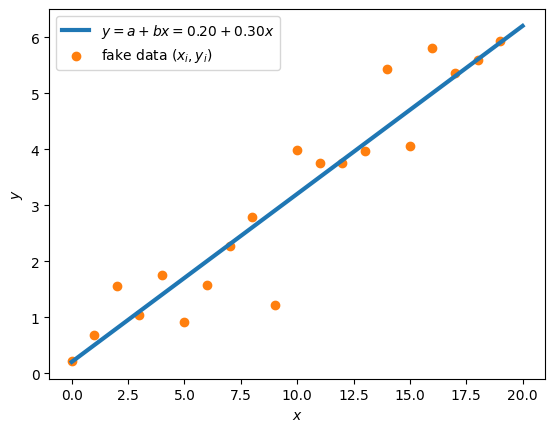

In [2]:
a = 0.2
b = 0.3
sigma = 0.5
n = 20
x = np.arange(n)
epsilon = stats.norm(0, sigma).rvs(n)
y = a + b * x + epsilon

plt.plot([0, 20], (a, a + b * 20), lw=3, label=f"$y = a + bx = {a:.2f} + {b:.2f}x$")
plt.scatter(x, y, color="C1", label="fake data $(x_i, y_i)$")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.show()

#### Fit a `LinearRegression` model to the fake data

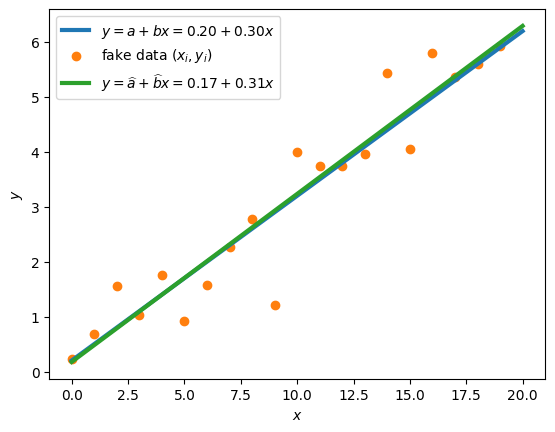

In [3]:
model = LinearRegression()
X = x.reshape(-1, 1)
model.fit(X, y)  # x must be a matrix, not a vector
ahat = model.intercept_
bhat = model.coef_[0]

plt.plot([0, 20], (a, a + b * 20), lw=3, label=f"$y = a + bx = {a:.2f} + {b:.2f}x$")
plt.scatter(x, y, color="C1", label="fake data $(x_i, y_i)$")
plt.plot(
    [0, 20],
    [ahat, ahat + bhat * 20],  # type: ignore
    color="C2",
    lw=3,
    label=f"$y = \\widehat{{a}} + \\widehat{{b}}x = {ahat:.2f} + {bhat:.2f}x$",
)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.show()

#### Uncertainty in regression coefficients

- The coefficients estimates $\hat{a}$ and $\hat{b}$ are random variables.

- We can generate their distributions by replicating our simulation.

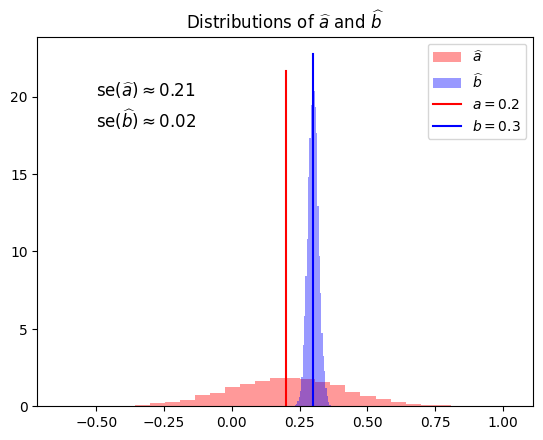

In [4]:
r = 10_000
epsilons = stats.norm(0, sigma).rvs(size=(n, r), random_state=42)
ys = a + b * X + epsilons
model = LinearRegression()
model.fit(X, ys)
ahats = model.intercept_
bhats = model.coef_.squeeze()
plt.hist(ahats, density=True, color=(1, 0, 0, 0.4), bins=30, label="$\\widehat{a}$")
plt.hist(bhats, density=True, color=(0, 0, 1, 0.4), bins=30, label="$\\widehat{b}$")
plt.plot([a, a], plt.ylim(), color=(1, 0, 0), label=f"$a = {a}$")
plt.plot([b, b], plt.ylim(), color=(0, 0, 1), label=f"$b = {b}$")
plt.text(
    -0.5,
    20,
    f"$\\operatorname{{se}}(\\widehat{{a}}) \\approx {ahats.std():.2f}$",
    fontsize=12,
)
plt.text(
    -0.5,
    18,
    f"$\\operatorname{{se}}(\\widehat{{b}}) \\approx {bhats.std():.2f}$",
    fontsize=12,
)
plt.title("Distributions of $\\widehat{a}$ and $\\widehat{b}$")
plt.legend()
plt.show()

- The distributions of $\hat{a}$ and $\hat{b}$ look normal because they are.

#### Residuals and estimating $\sigma$

Predicted $y$-values:
$$
\hat{y}_i = \hat{a} + \hat{b}x_i
$$

Residuals:
$$
\hat{y}_i - y_i
$$

Residual sum of squares:
$$
\operatorname{RSS} = \sum_{i < n}(\hat{y}_i - y_i)^2
$$

Estimate $\sigma^2$:
$$
s^2 = \frac{\operatorname{RSS}}{n - 2}
$$

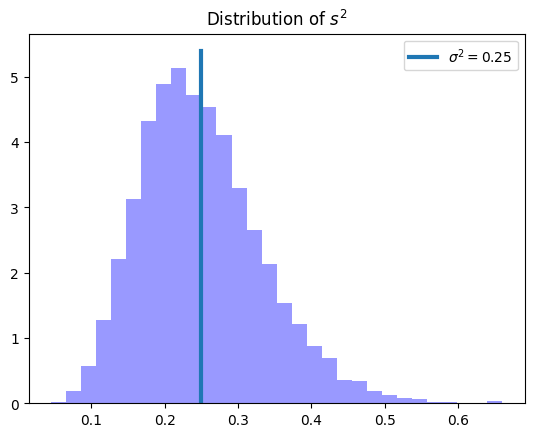

In [5]:
yhats = model.predict(X)
assert np.allclose(yhats, model.intercept_ + X @ model.coef_.T)
rsss = np.sum((yhats - ys) ** 2, axis=0)
s2s = rsss / (n - 2)
plt.hist(s2s, bins=30, color=(0, 0, 1, 0.4), density=True)
plt.title("Distribution of $s^2$")
plt.plot([sigma**2, sigma**2], plt.ylim(), "C0", lw=3, label=f"$\\sigma^2={sigma**2}$")
plt.legend()
plt.show()

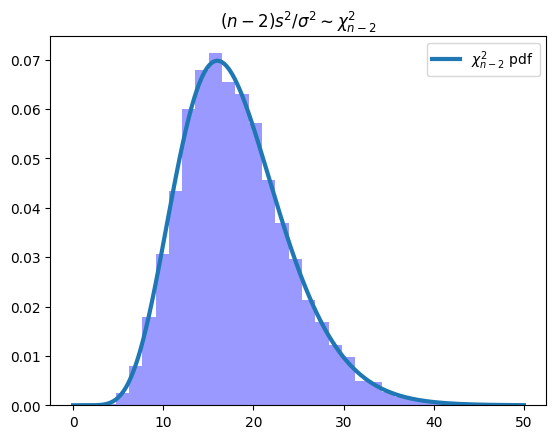

In [6]:
plt.hist((n - 2) * s2s / sigma**2, bins=30, color=(0, 0, 1, 0.4), density=True)
mesh = np.linspace(0, 50, 1000)
plt.plot(mesh, stats.chi2(n - 2).pdf(mesh), lw=3, label="$\\chi^2_{n - 2}$ pdf")
plt.title("$(n - 2)s^2/\\sigma^2\\sim\\chi^2_{n - 2}$")
plt.legend()
plt.show()

- The `LinearRegression` class doesn't compute standard errors for coefficient estimates because `scikit-learn` doesn't concern itself with statistical inference. For that, we'll use PyMC.